In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import sklearn
import random


In [50]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [51]:
filename = 'Dataset/Sensor_Discrimination_normalized.csv'
df=pd.read_csv(filename)
# shuffle the DataFrame rows
df = df.sample(frac = 1) #frac = fraction
dataset=df.iloc[:,:-1]
label=df.iloc[:,-1]
print(dataset)
print(label)

            F2        F3        F1       F11        F4        F6       F10  \
1986  0.128471  0.947847  0.819980  0.315957  0.854316  0.510995  0.783697   
984   0.592513  0.906460  0.773164  0.186525  0.858307  0.307587  0.270520   
221   0.397861  0.546770  0.263663  0.172500  0.414768  0.034552  0.182925   
222   0.394439  0.529610  0.252693  0.157784  0.433062  0.050330  0.191265   
1717  0.798930  0.571164  0.365916  0.206028  0.486446  0.080539  0.295745   
...        ...       ...       ...       ...       ...       ...       ...   
1917  0.245989  0.911339  0.738492  0.213652  0.734908  0.422760  0.322666   
603   0.240000  0.876346  0.839961  0.199823  0.844171  0.507697  0.299511   
1044  0.119850  0.961810  0.924192  0.320745  0.976218  0.672897  0.954443   
212   0.423743  0.514637  0.264251  0.182801  0.433228  0.045629  0.173042   
2011  0.344385  0.955754  0.764153  0.221631  0.759521  0.360363  0.276544   

            F9        F5      F7      F12       F8  
1986  0.39

# RFE implement

In [52]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR


estimator = SVR(kernel="linear")
model = RFE(estimator, n_features_to_select=3, step=1)
model.fit(dataset,label)



RFE(estimator=SVR(kernel='linear'), n_features_to_select=3)

In [53]:

compressed_dataset_X= model.transform(dataset) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X))
print(len(compressed_dataset_X[0]))
print(compressed_dataset_X)

<class 'numpy.ndarray'>
3
[[0.81998041 0.31595745 0.39106754]
 [0.77316357 0.18652482 0.30450254]
 [0.26366308 0.1725     0.10061728]
 ...
 [0.92419197 0.32074468 0.77269426]
 [0.26425073 0.18280142 0.04433551]
 [0.76415279 0.22163121 0.19015977]]


In [54]:
dataset_arr=dataset.to_numpy()


In [55]:
# from NecessaryModules.splitData import split_data
X_train, X_test, y_train, y_test = train_test_split(dataset_arr, label, test_size=0.3, random_state=42)
print(len(X_train))

1548


In [56]:
compressed_dataset_X_train= model.transform(X_train) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_train))
print(len(compressed_dataset_X_train))
print(compressed_dataset_X_train)

compressed_dataset_X_test= model.transform(X_test) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_test))
print(len(compressed_dataset_X_test))
print(compressed_dataset_X_test)

<class 'numpy.ndarray'>
1548
[[0.59921645 0.18741135 0.18039216]
 [0.81802155 0.29911348 0.33907044]
 [0.74652302 0.24946809 0.26993464]
 ...
 [0.91204701 0.93847518 0.85003631]
 [0.80901077 0.1785461  0.21895425]
 [0.76278159 0.48652482 0.42120552]]
<class 'numpy.ndarray'>
664
[[0.88716944 0.97943262 0.86782861]
 [0.87424094 0.94769504 0.6503268 ]
 [0.29598433 0.21010638 0.08511256]
 ...
 [0.81684623 0.29219858 0.40813362]
 [0.35200784 0.17960993 0.06782861]
 [0.6920666  0.18067376 0.43572985]]


# tune XG Boost

In [57]:
# train the model with random parameter
import xgboost as xgb
# Preparing the regressor and fitting data with some parameters
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 1, 
                          learning_rate = 0.3,
                          max_depth = 15, 
                          alpha = 10, 
                          n_estimators = 100, 
                          verbose=1, 
                          min_child_weight = 1, 
                          colsample_bylevel = 1, 
                          reg_alpha = 2) 

xg_reg.fit(compressed_dataset_X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [58]:
# Finding mean absolute error
preds = xg_reg.predict(compressed_dataset_X_test)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.37801204819277107

In [59]:
# Defining the best parameter with optuna
from sklearn.model_selection import KFold
K = 5 # 5 fold cross validation
kf = KFold(n_splits = K, random_state = 42, shuffle = True)


train_tunned = np.array(compressed_dataset_X)
target_train_tunned = np.array(label)

# test = np.array(X)
# target_train = df_train['congestion'].values

# test_preds = np.zeros((len(test)))
oof_preds = np.zeros((len(train_tunned)))
abs_error_arr=[]
def objective(trial):

 for train_index, val_index in (kf.split(compressed_dataset_X)):
    train_X, valid_X = train_tunned[train_index], train_tunned[val_index]
    train_Y, valid_Y = target_train_tunned[train_index], target_train_tunned[val_index]
    
        
        # train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25,random_state=0)
    param = {
            # 'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process 
            'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [1e-5,1e-4,1e-3,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.04,0.08,0.12,0.20, 0.24, 0.30, 0.38, 0.42, 0.48, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0]),
            'n_estimators': trial.suggest_int('n_estimators', 1, 300),
            'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20,25,30,35,40]),
            'random_state': trial.suggest_categorical('random_state', [24,48,2020]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        }
    model = xgb.XGBRegressor(**param)  
        
    model.fit(train_X,train_Y,eval_set=[(valid_X,valid_Y)],early_stopping_rounds=100,verbose=False)
        
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds # preds gives total 3846 predicted value for valid_X


 
 print(len(oof_preds))
      
 mae = mean_absolute_error(target_train_tunned, oof_preds)
        
 return mae

In [60]:
# this is the main optuna for optimizing a object-->"objective"
study = optuna.create_study(direction='minimize',study_name="XG_tune")

[I 2024-02-12 08:39:25,737] A new study created in memory with name: XG_tune


In [61]:

study.optimize(objective, n_trials=100) # 150 bar "objective" object ke trial kore kore dekhbe, here total 5*100=750
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-12 08:39:26,142] Trial 0 finished with value: 0.263960038211416 and parameters: {'lambda': 4.769367698538649, 'alpha': 0.023310961465198912, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.8, 'n_estimators': 74, 'max_depth': 25, 'random_state': 24, 'min_child_weight': 130}. Best is trial 0 with value: 0.263960038211416.


2212


[I 2024-02-12 08:39:26,722] Trial 1 finished with value: 0.3069549446450176 and parameters: {'lambda': 0.6546465517491331, 'alpha': 0.0722717786051536, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'subsample': 0.4, 'learning_rate': 0.3, 'n_estimators': 160, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 144}. Best is trial 0 with value: 0.263960038211416.


2212


[I 2024-02-12 08:39:28,749] Trial 2 finished with value: 0.22479762489455676 and parameters: {'lambda': 0.005748774819421153, 'alpha': 0.08070061135164655, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6, 'subsample': 0.8, 'learning_rate': 0.12, 'n_estimators': 264, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 30}. Best is trial 2 with value: 0.22479762489455676.


2212


[I 2024-02-12 08:39:29,561] Trial 3 finished with value: 0.23505463361867263 and parameters: {'lambda': 0.002922079193271884, 'alpha': 0.0037086264382435808, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.7, 'learning_rate': 0.38, 'n_estimators': 183, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 134}. Best is trial 2 with value: 0.22479762489455676.


2212


[I 2024-02-12 08:39:30,249] Trial 4 finished with value: 0.3119308951266184 and parameters: {'lambda': 0.7111337258431316, 'alpha': 0.003041950768583577, 'colsample_bytree': 0.6, 'colsample_bylevel': 1.0, 'subsample': 0.6, 'learning_rate': 1.0, 'n_estimators': 228, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 197}. Best is trial 2 with value: 0.22479762489455676.


2212


[I 2024-02-12 08:39:30,981] Trial 5 finished with value: 0.5895674887768398 and parameters: {'lambda': 0.01133650441514918, 'alpha': 0.07894125943955396, 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'subsample': 0.4, 'learning_rate': 0.003, 'n_estimators': 244, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 258}. Best is trial 2 with value: 0.22479762489455676.


2212


[I 2024-02-12 08:39:31,621] Trial 6 finished with value: 0.2851253267347143 and parameters: {'lambda': 1.372940270260532, 'alpha': 0.002028833556420449, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 0.8, 'learning_rate': 0.04, 'n_estimators': 151, 'max_depth': 25, 'random_state': 48, 'min_child_weight': 193}. Best is trial 2 with value: 0.22479762489455676.


2212


[I 2024-02-12 08:39:32,058] Trial 7 finished with value: 0.6108387251120149 and parameters: {'lambda': 0.001523817222938931, 'alpha': 0.004255634374329888, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.002, 'n_estimators': 74, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 82}. Best is trial 2 with value: 0.22479762489455676.


2212


[I 2024-02-12 08:39:32,858] Trial 8 finished with value: 0.30627430638769526 and parameters: {'lambda': 0.0013610364948866505, 'alpha': 0.01989668347322495, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6, 'subsample': 0.6, 'learning_rate': 0.42, 'n_estimators': 204, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 131}. Best is trial 2 with value: 0.22479762489455676.


2212


[I 2024-02-12 08:39:33,313] Trial 9 finished with value: 0.35999639786398424 and parameters: {'lambda': 0.14931919292348939, 'alpha': 1.1055723619037041, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.8, 'subsample': 0.4, 'learning_rate': 0.2, 'n_estimators': 127, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 176}. Best is trial 2 with value: 0.22479762489455676.


2212


[I 2024-02-12 08:39:34,387] Trial 10 finished with value: 0.3075026427274332 and parameters: {'lambda': 0.02484692485153008, 'alpha': 8.579541491673101, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.3, 'subsample': 0.5, 'learning_rate': 0.12, 'n_estimators': 290, 'max_depth': 40, 'random_state': 2020, 'min_child_weight': 7}. Best is trial 2 with value: 0.22479762489455676.


2212


[I 2024-02-12 08:39:35,560] Trial 11 finished with value: 0.23885001695204283 and parameters: {'lambda': 0.008785245234674997, 'alpha': 0.5866729515159076, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'subsample': 0.7, 'learning_rate': 0.38, 'n_estimators': 298, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 9}. Best is trial 2 with value: 0.22479762489455676.


2212


[I 2024-02-12 08:39:35,781] Trial 12 finished with value: 0.31401012509481924 and parameters: {'lambda': 0.004633815481097568, 'alpha': 0.49149139772277034, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'subsample': 0.7, 'learning_rate': 0.12, 'n_estimators': 22, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 69}. Best is trial 2 with value: 0.22479762489455676.


2212


[I 2024-02-12 08:39:36,763] Trial 13 finished with value: 0.22395872825254168 and parameters: {'lambda': 0.0670076805506729, 'alpha': 0.013679062280470188, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.7, 'learning_rate': 0.38, 'n_estimators': 205, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 74}. Best is trial 13 with value: 0.22395872825254168.


2212


[I 2024-02-12 08:39:38,345] Trial 14 finished with value: 0.5062250125930926 and parameters: {'lambda': 0.05984013723840808, 'alpha': 0.020335796592672498, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.6, 'subsample': 0.8, 'learning_rate': 0.004, 'n_estimators': 255, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 59}. Best is trial 13 with value: 0.22395872825254168.


2212


[I 2024-02-12 08:39:39,646] Trial 15 finished with value: 0.2613446580379348 and parameters: {'lambda': 0.12014687577979398, 'alpha': 0.17799063817685726, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.9, 'n_estimators': 264, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 44}. Best is trial 13 with value: 0.22395872825254168.


2212


[I 2024-02-12 08:39:40,929] Trial 16 finished with value: 0.25323893001884523 and parameters: {'lambda': 0.04529528297777309, 'alpha': 0.01054242567202861, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'subsample': 0.5, 'learning_rate': 0.7, 'n_estimators': 206, 'max_depth': 30, 'random_state': 48, 'min_child_weight': 93}. Best is trial 13 with value: 0.22395872825254168.


2212


[I 2024-02-12 08:39:41,946] Trial 17 finished with value: 0.5697379147408237 and parameters: {'lambda': 0.24612525423642137, 'alpha': 0.20687602943775252, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8, 'subsample': 0.8, 'learning_rate': 0.005, 'n_estimators': 101, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 32}. Best is trial 13 with value: 0.22395872825254168.


2212


[I 2024-02-12 08:39:43,112] Trial 18 finished with value: 0.6332499210539174 and parameters: {'lambda': 0.017800250897123636, 'alpha': 3.0791045730451923, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 183, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 96}. Best is trial 13 with value: 0.22395872825254168.


2212


[I 2024-02-12 08:39:44,178] Trial 19 finished with value: 0.3159100978964077 and parameters: {'lambda': 0.00531067179091745, 'alpha': 0.03673224910955271, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.9, 'subsample': 0.8, 'learning_rate': 0.5, 'n_estimators': 222, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 278}. Best is trial 13 with value: 0.22395872825254168.


2212


[I 2024-02-12 08:39:46,655] Trial 20 finished with value: 0.20322280831203546 and parameters: {'lambda': 6.853499352361944, 'alpha': 0.0010451984285081998, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.08, 'n_estimators': 262, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 27}. Best is trial 20 with value: 0.20322280831203546.


2212


[I 2024-02-12 08:39:49,128] Trial 21 finished with value: 0.2098224341603341 and parameters: {'lambda': 8.426423706651514, 'alpha': 0.0012676909113508647, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.08, 'n_estimators': 270, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 34}. Best is trial 20 with value: 0.20322280831203546.


2212


[I 2024-02-12 08:39:50,904] Trial 22 finished with value: 0.2448130422819656 and parameters: {'lambda': 9.205747869530823, 'alpha': 0.0013775727749109994, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.08, 'n_estimators': 274, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 107}. Best is trial 20 with value: 0.20322280831203546.


2212


[I 2024-02-12 08:39:53,011] Trial 23 finished with value: 0.2079788244821711 and parameters: {'lambda': 2.8018376278689643, 'alpha': 0.008690303283414883, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.7, 'learning_rate': 0.08, 'n_estimators': 238, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 46}. Best is trial 20 with value: 0.20322280831203546.


2212


[I 2024-02-12 08:39:56,137] Trial 24 finished with value: 0.18017710110734286 and parameters: {'lambda': 2.7811190472554967, 'alpha': 0.0012916807343372081, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.08, 'n_estimators': 238, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 1}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:39:58,270] Trial 25 finished with value: 0.1878147079989921 and parameters: {'lambda': 2.7336357046102866, 'alpha': 0.00697938105676814, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.08, 'n_estimators': 231, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 8}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:00,527] Trial 26 finished with value: 0.32984316767366845 and parameters: {'lambda': 2.319011527456708, 'alpha': 0.0010136273609705059, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.007, 'n_estimators': 170, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 4}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:03,825] Trial 27 finished with value: 0.22584311259024403 and parameters: {'lambda': 0.5145377026028246, 'alpha': 0.004095870059893897, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 299, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 22}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:07,642] Trial 28 finished with value: 0.1859355907549658 and parameters: {'lambda': 1.5262947524730432, 'alpha': 0.00698712198903101, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.08, 'n_estimators': 221, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 2}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:08,742] Trial 29 finished with value: 0.62221249700886 and parameters: {'lambda': 3.3664384752761154, 'alpha': 0.006463579611976139, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.4, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 130, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 55}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:11,690] Trial 30 finished with value: 0.31318423895007014 and parameters: {'lambda': 1.3956192283941302, 'alpha': 0.039845407461964334, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 'subsample': 0.6, 'learning_rate': 0.006, 'n_estimators': 224, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 6}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:14,092] Trial 31 finished with value: 0.28473174888270136 and parameters: {'lambda': 5.860191325716435, 'alpha': 0.0017471293017432728, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.008, 'n_estimators': 245, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 19}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:25,200] Trial 32 finished with value: 0.23658442307196983 and parameters: {'lambda': 1.3113500919772014, 'alpha': 0.002495694495904689, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.08, 'n_estimators': 196, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 1}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:26,973] Trial 33 finished with value: 0.20879352120682335 and parameters: {'lambda': 4.781732352720505, 'alpha': 0.006169606085219858, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.9, 'subsample': 0.7, 'learning_rate': 0.24, 'n_estimators': 284, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 29}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:28,723] Trial 34 finished with value: 0.6692900140289804 and parameters: {'lambda': 0.373551430003682, 'alpha': 0.00253535905596434, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 1e-05, 'n_estimators': 218, 'max_depth': 35, 'random_state': 24, 'min_child_weight': 49}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:30,190] Trial 35 finished with value: 0.6651491538148245 and parameters: {'lambda': 0.8957402954393245, 'alpha': 0.005453058572299763, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.6, 'subsample': 0.5, 'learning_rate': 0.0001, 'n_estimators': 248, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 114}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:31,782] Trial 36 finished with value: 0.5704964836133108 and parameters: {'lambda': 2.1423590082844264, 'alpha': 0.038526087758016254, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.4, 'learning_rate': 0.001, 'n_estimators': 233, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 19}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:33,073] Trial 37 finished with value: 0.3120947225255324 and parameters: {'lambda': 4.582071796564521, 'alpha': 0.0010811026325891623, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.6, 'n_estimators': 178, 'max_depth': 25, 'random_state': 48, 'min_child_weight': 64}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:34,649] Trial 38 finished with value: 0.6186183227283398 and parameters: {'lambda': 0.9086124976463713, 'alpha': 0.0024720902408324843, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 271, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 169}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:35,666] Trial 39 finished with value: 0.31831383938243474 and parameters: {'lambda': 1.7045862497289965, 'alpha': 0.013429004417696153, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.8, 'subsample': 0.6, 'learning_rate': 0.48, 'n_estimators': 192, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 230}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:36,948] Trial 40 finished with value: 0.3344667182854675 and parameters: {'lambda': 3.9555347327118255, 'alpha': 0.0034224533346420105, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.4, 'learning_rate': 0.009, 'n_estimators': 162, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 38}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:39,105] Trial 41 finished with value: 0.20901208634264487 and parameters: {'lambda': 2.6563560898109735, 'alpha': 0.008223361680494099, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.7, 'learning_rate': 0.08, 'n_estimators': 238, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 46}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:41,631] Trial 42 finished with value: 0.1943462393775381 and parameters: {'lambda': 5.909876429706196, 'alpha': 0.008871250208630438, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.7, 'learning_rate': 0.08, 'n_estimators': 254, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 20}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:43,871] Trial 43 finished with value: 0.5677690808585496 and parameters: {'lambda': 6.883964868758847, 'alpha': 0.004552842673577258, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.3, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 262, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 20}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:45,704] Trial 44 finished with value: 0.22341801234101424 and parameters: {'lambda': 9.856871227415619, 'alpha': 0.0019956820790446687, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.08, 'n_estimators': 281, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 14}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:47,863] Trial 45 finished with value: 0.568768734284163 and parameters: {'lambda': 5.377535411305016, 'alpha': 0.017216099349873483, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 253, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 32}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:49,231] Trial 46 finished with value: 0.2600893103838629 and parameters: {'lambda': 0.9779918093058012, 'alpha': 0.05879857675921449, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'subsample': 0.7, 'learning_rate': 1.0, 'n_estimators': 223, 'max_depth': 25, 'random_state': 48, 'min_child_weight': 83}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:49,481] Trial 47 finished with value: 0.6667474234783197 and parameters: {'lambda': 3.4437656510174115, 'alpha': 0.027030707803852024, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.9, 'subsample': 0.5, 'learning_rate': 0.001, 'n_estimators': 7, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 5}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:51,537] Trial 48 finished with value: 0.5890627339832606 and parameters: {'lambda': 0.5020703402504219, 'alpha': 0.0016861723735286886, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 212, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 25}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:52,747] Trial 49 finished with value: 0.31751768334047065 and parameters: {'lambda': 0.25325741435729293, 'alpha': 0.01112759599972111, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.5, 'subsample': 0.6, 'learning_rate': 0.8, 'n_estimators': 257, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 61}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:53,213] Trial 50 finished with value: 0.3188501069485168 and parameters: {'lambda': 1.8209277377766935, 'alpha': 0.0033313336576493227, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.7, 'subsample': 0.7, 'learning_rate': 0.3, 'n_estimators': 55, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 150}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:55,303] Trial 51 finished with value: 0.207948736379604 and parameters: {'lambda': 2.8793709445414493, 'alpha': 0.006521747229623779, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.7, 'learning_rate': 0.08, 'n_estimators': 236, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 46}. Best is trial 24 with value: 0.18017710110734286.


2212


[I 2024-02-12 08:40:58,446] Trial 52 finished with value: 0.17146186188996346 and parameters: {'lambda': 6.533155408911733, 'alpha': 0.0071542155423214545, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.7, 'learning_rate': 0.08, 'n_estimators': 235, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 1}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:01,547] Trial 53 finished with value: 0.17312974418172652 and parameters: {'lambda': 6.548284953835703, 'alpha': 0.0933761450451271, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.7, 'learning_rate': 0.08, 'n_estimators': 287, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 1}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:06,367] Trial 54 finished with value: 0.17506499281212554 and parameters: {'lambda': 4.4604455602092274, 'alpha': 0.1581553829964129, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.04, 'n_estimators': 286, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 1}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:10,324] Trial 55 finished with value: 0.6104395447760336 and parameters: {'lambda': 4.052353192620616, 'alpha': 0.16033600128846953, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 289, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 1}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:13,551] Trial 56 finished with value: 0.18083128241402624 and parameters: {'lambda': 1.2643563220325114, 'alpha': 0.317673523193999, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.04, 'n_estimators': 279, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 15}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:15,067] Trial 57 finished with value: 0.32038668600471215 and parameters: {'lambda': 1.243026697789018, 'alpha': 0.4223325571065322, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.04, 'n_estimators': 278, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 221}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:18,850] Trial 58 finished with value: 0.21658495355398819 and parameters: {'lambda': 0.6357528443374937, 'alpha': 0.11416525888152987, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.04, 'n_estimators': 290, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 13}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:21,249] Trial 59 finished with value: 0.40160643504713583 and parameters: {'lambda': 7.513878716404409, 'alpha': 1.2200719679203185, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.003, 'n_estimators': 296, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 32}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:23,583] Trial 60 finished with value: 0.5567995429470138 and parameters: {'lambda': 2.0895993937222372, 'alpha': 0.3193582104508274, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 270, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 39}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:25,609] Trial 61 finished with value: 0.5807820889445369 and parameters: {'lambda': 3.345759197972055, 'alpha': 0.8823834118078768, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 197, 'max_depth': 30, 'random_state': 48, 'min_child_weight': 11}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:30,520] Trial 62 finished with value: 0.17583310561692284 and parameters: {'lambda': 1.7953718293920977, 'alpha': 0.2610490433995727, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.04, 'n_estimators': 213, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 1}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:35,048] Trial 63 finished with value: 0.1797914434235735 and parameters: {'lambda': 1.6922134799272088, 'alpha': 0.26788458138275767, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.04, 'n_estimators': 213, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 2}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:38,813] Trial 64 finished with value: 0.17889585591390833 and parameters: {'lambda': 9.857501395071038, 'alpha': 0.2647751543678863, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.04, 'n_estimators': 300, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 12}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:40,514] Trial 65 finished with value: 0.19538473233013617 and parameters: {'lambda': 6.286310398505, 'alpha': 0.1197615160436811, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.04, 'n_estimators': 150, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 26}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:42,423] Trial 66 finished with value: 0.5942121622898695 and parameters: {'lambda': 7.778210570738745, 'alpha': 0.24532423867989767, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 206, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 14}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:47,063] Trial 67 finished with value: 0.5580479570851403 and parameters: {'lambda': 4.634829111781143, 'alpha': 0.05939153848941919, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 298, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 2}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:48,946] Trial 68 finished with value: 0.4966391475760053 and parameters: {'lambda': 9.987254347765369, 'alpha': 0.1468961596849316, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.002, 'n_estimators': 243, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 56}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:50,439] Trial 69 finished with value: 0.21661611085678248 and parameters: {'lambda': 4.569251278671788, 'alpha': 0.09270531502618964, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.42, 'n_estimators': 269, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 75}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:52,646] Trial 70 finished with value: 0.3169729341342321 and parameters: {'lambda': 2.4922958054410436, 'alpha': 0.6611158786539064, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.3, 'subsample': 1.0, 'learning_rate': 0.2, 'n_estimators': 290, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 40}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:55,144] Trial 71 finished with value: 0.17851949707188616 and parameters: {'lambda': 1.2257646728993763, 'alpha': 0.2820852306860589, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.04, 'n_estimators': 281, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 12}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:56,678] Trial 72 finished with value: 0.31275777118461046 and parameters: {'lambda': 3.4149647372518084, 'alpha': 0.22833249813421197, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.04, 'n_estimators': 284, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 299}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:41:59,244] Trial 73 finished with value: 0.17503669294765592 and parameters: {'lambda': 0.00326490307348196, 'alpha': 1.5311553901454051, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.04, 'n_estimators': 261, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 9}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:02,061] Trial 74 finished with value: 0.1808981588796149 and parameters: {'lambda': 0.002110728761606006, 'alpha': 1.5486443935248273, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.04, 'n_estimators': 299, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 12}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:04,227] Trial 75 finished with value: 0.5613997675087741 and parameters: {'lambda': 0.004412349030308534, 'alpha': 3.195332277243886, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 259, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 25}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:06,720] Trial 76 finished with value: 0.34775360668533356 and parameters: {'lambda': 0.03901057854144291, 'alpha': 0.3968683040358213, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.04, 'n_estimators': 248, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 10}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:09,010] Trial 77 finished with value: 0.49963789794317853 and parameters: {'lambda': 0.0010265548179720768, 'alpha': 0.6164257263185056, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.004, 'n_estimators': 267, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 34}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:11,327] Trial 78 finished with value: 0.5478019281063115 and parameters: {'lambda': 0.013109362335920145, 'alpha': 0.27069626413765335, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 277, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 21}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:12,792] Trial 79 finished with value: 0.30737346184920356 and parameters: {'lambda': 0.19284561717990645, 'alpha': 7.645908717198304, 'colsample_bytree': 0.3, 'colsample_bylevel': 1.0, 'subsample': 0.4, 'learning_rate': 0.9, 'n_estimators': 288, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 8}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:14,575] Trial 80 finished with value: 0.5853151373470886 and parameters: {'lambda': 0.09615767464074669, 'alpha': 0.19405359070716333, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 214, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 51}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:17,209] Trial 81 finished with value: 0.5654086983117661 and parameters: {'lambda': 7.144381966148704, 'alpha': 0.13832337387993726, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.5, 'learning_rate': 0.001, 'n_estimators': 244, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 2}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:19,602] Trial 82 finished with value: 0.5729077187304471 and parameters: {'lambda': 2.148709994371661, 'alpha': 0.07615545602227285, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 230, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 16}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:21,709] Trial 83 finished with value: 0.34294853009835935 and parameters: {'lambda': 1.6735050176914248, 'alpha': 2.0660785890858193, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.6, 'learning_rate': 0.005, 'n_estimators': 260, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 27}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:24,982] Trial 84 finished with value: 0.5501433822981487 and parameters: {'lambda': 5.493662070174769, 'alpha': 0.451414389046632, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 273, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 6}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:27,088] Trial 85 finished with value: 0.6059854667074641 and parameters: {'lambda': 4.014562445434316, 'alpha': 0.8323249054017201, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8, 'subsample': 0.4, 'learning_rate': 0.001, 'n_estimators': 189, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 20}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:32,768] Trial 86 finished with value: 0.5630732676650905 and parameters: {'lambda': 8.100917575161718, 'alpha': 0.3014318867472396, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.3, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 254, 'max_depth': 25, 'random_state': 48, 'min_child_weight': 1}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:34,381] Trial 87 finished with value: 0.5858078054127167 and parameters: {'lambda': 1.063924352357172, 'alpha': 0.19035379406998545, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.9, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 227, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 137}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:35,367] Trial 88 finished with value: 0.23371201290612809 and parameters: {'lambda': 0.6319785501651214, 'alpha': 0.02893267599838167, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.5, 'n_estimators': 100, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 120}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:38,231] Trial 89 finished with value: 0.5718856349344926 and parameters: {'lambda': 0.009368173329626805, 'alpha': 0.09436844434056467, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'subsample': 0.5, 'learning_rate': 0.001, 'n_estimators': 284, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 37}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:41,067] Trial 90 finished with value: 0.5650396571236967 and parameters: {'lambda': 0.745601334361385, 'alpha': 0.06202793666110724, 'colsample_bytree': 0.9, 'colsample_bylevel': 1.0, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 266, 'max_depth': 30, 'random_state': 48, 'min_child_weight': 28}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:44,560] Trial 91 finished with value: 0.17563615931636084 and parameters: {'lambda': 1.394204462673899, 'alpha': 0.3540021796891966, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.04, 'n_estimators': 283, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 10}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:48,759] Trial 92 finished with value: 0.5368427255647308 and parameters: {'lambda': 0.022758586541715742, 'alpha': 0.36475640112437147, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 291, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 10}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:52,387] Trial 93 finished with value: 0.18468828695516393 and parameters: {'lambda': 2.9231272261277654, 'alpha': 0.23746239523670695, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.04, 'n_estimators': 239, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 17}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:54,058] Trial 94 finished with value: 0.2410596701962609 and parameters: {'lambda': 1.8427925383376582, 'alpha': 0.5902105567234701, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.7, 'n_estimators': 278, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 168}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:57,641] Trial 95 finished with value: 0.5522226436875397 and parameters: {'lambda': 5.119294020870698, 'alpha': 0.5155188817525382, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.6, 'learning_rate': 0.001, 'n_estimators': 292, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 1}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:42:59,654] Trial 96 finished with value: 0.18025779801427155 and parameters: {'lambda': 0.3787620610742176, 'alpha': 0.04686183086447896, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.7, 'learning_rate': 0.04, 'n_estimators': 250, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 8}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:43:01,327] Trial 97 finished with value: 0.6272619189879778 and parameters: {'lambda': 1.4972812477525113, 'alpha': 4.249986349165012, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.9, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 211, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 22}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:43:04,057] Trial 98 finished with value: 0.5558201239779457 and parameters: {'lambda': 3.727807640385157, 'alpha': 0.8025308480996572, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 264, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 15}. Best is trial 52 with value: 0.17146186188996346.


2212


[I 2024-02-12 08:43:06,355] Trial 99 finished with value: 0.6142938175048362 and parameters: {'lambda': 2.4414694249556512, 'alpha': 0.14584416914201787, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 275, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 41}. Best is trial 52 with value: 0.17146186188996346.


2212
Number of finished trials: 100
Best trial: {'lambda': 6.533155408911733, 'alpha': 0.0071542155423214545, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 0.7, 'learning_rate': 0.08, 'n_estimators': 235, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 1}


In [72]:
#evaluate the trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.17146186188996346
  Params: 
    lambda: 6.533155408911733
    alpha: 0.0071542155423214545
    colsample_bytree: 1.0
    colsample_bylevel: 0.7
    subsample: 0.7
    learning_rate: 0.08
    n_estimators: 235
    max_depth: 11
    random_state: 48
    min_child_weight: 1


# fit the XG-Boost

In [73]:

K = 5 # 5 fold cross validation
kf = KFold(n_splits = K, random_state = 42, shuffle = True)

In [74]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions

from tqdm import tqdm
train = np.array(compressed_dataset_X_train)
target_train = np.array(y_train)

test = np.array(compressed_dataset_X_test)
# target_train = df_train['congestion'].values

test_preds = np.zeros((len(test)))
oof_preds = np.zeros((len(train)))
for train_index, val_index in tqdm(kf.split(compressed_dataset_X_train), total=5):
    train_X, valid_X = train[train_index], train[val_index]
    train_y, valid_y = target_train[train_index], target_train[val_index]
    xgb_params = study.best_trial.params
    model_xb = xgb.XGBRegressor(**xgb_params)
    model_xb.fit(train_X, train_y,eval_set=[(valid_X,valid_y)],early_stopping_rounds=100,verbose=False)
    # for train accuracy
    preds = model_xb.predict(valid_X)
    oof_preds[val_index] = preds
    # for test accuracy
    preds = model_xb.predict(test)
    test_preds += (preds)/5
print(np.abs(oof_preds-target_train).mean())

100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

0.1731466856244855


In [75]:
#validation accuracy
# target_test = np.array(y_test_2)
from sklearn.metrics import accuracy_score


valid_Acc=accuracy_score(target_train,oof_preds.round())
print(valid_Acc)

0.8856589147286822


In [76]:
target_test=np.array(y_test)
# another technique for calculate test accuracy
test_Acc_xb=accuracy_score(target_test,test_preds.round())
print(test_Acc_xb)

0.8885542168674698


In [77]:
# train accuracy
train_Acc=model_xb.score(compressed_dataset_X_train,y_train)
print(train_Acc)

0.9261254880900093


In [78]:
# test_accuracy
test_Acc=model_xb.score(compressed_dataset_X_test,y_test)
print(test_Acc)

0.764649985935977


# confusion matrix

In [69]:
from sklearn.base import is_classifier


is_classifier(model_xb) # because XGBoost is not included in sklearn

False

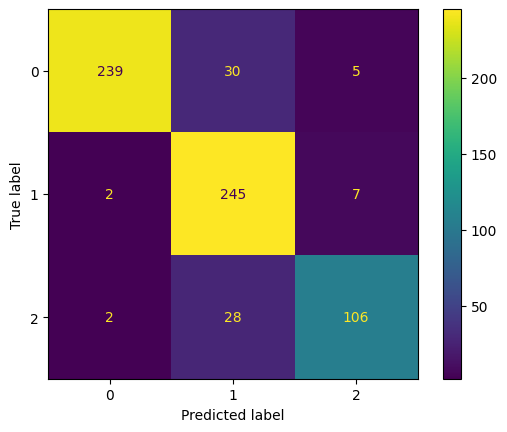

In [70]:
############# plot confusion matrix ############

from sklearn import metrics

cm = metrics.confusion_matrix(y_test, test_preds.round())
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.pink)


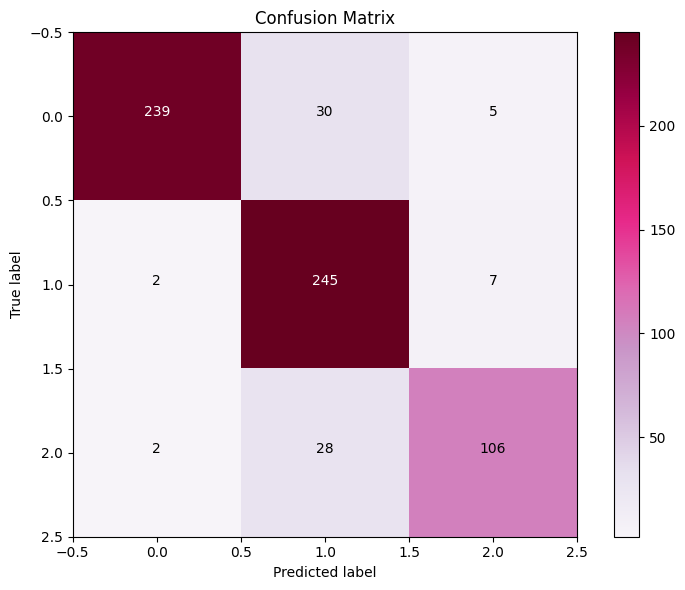

In [71]:
# Plot confusion matrix with custom color map

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)  # Set cmap to custom color map
plt.title('Confusion Matrix')
plt.colorbar()

# Adding ticks and labels
# tick_marks = np.arange(len(cm))
# plt.xticks(tick_marks, ['Class 0', 'Class 1', 'Class 2','Class 3','Class 4','class 5','class 6'])
# plt.yticks(tick_marks, ['Class 0', 'Class 1', 'Class 2'])

# Adding annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), #'d = integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() #improves the layout of plots by preventing overlapping elements such as axis labels, tick labels, and titles
plt.show()